<center><b>ANÁLISIS DE SENTIMIENTO MEDIANTE CLASIFICACIÓN DE TEXTO CON BERT</b></center>

Las emociones juegan un papel vital en la comunicación humana, y detectar emociones a partir de datos de texto es una tarea desafiante. La capacidad de reconocer automáticamente las emociones del texto tiene muchas aplicaciones prácticas, como el análisis de sentimientos, el seguimiento de las redes sociales y el análisis de comentarios de los clientes.

En este proyecto, discutiremos el principio de funcionamiento de un modelo de reconocimiento de emociones de texto y sus terminologías importantes. También proporcionaremos una descripción detallada de la arquitectura del modelo utilizado y su proceso de entrenamiento. Finalmente, concluiremos evaluando el modelo usando matriz de confusión e informe de clasificación. Para realizar de forma adecuada el análisis de sentimentos, este proyecto se basa en el código disponible de forma pública en [TensorFlow](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=es-419)
, eso si, cambiando hiper parametros y modificando el código para realizar un mejor aprendizaje.

Composición del conjunto de datos:

<b>Variable Predictora (Text):</b>
* Frases de distintas temáticas.

<b>Variable Objetivo (Emotion):</b>
* 0: triste
* 1: feliz

<b>Enlace al data set de Kaggle:</b> https://www.kaggle.com/datasets/shreejitcheela/text-emotion-recognition

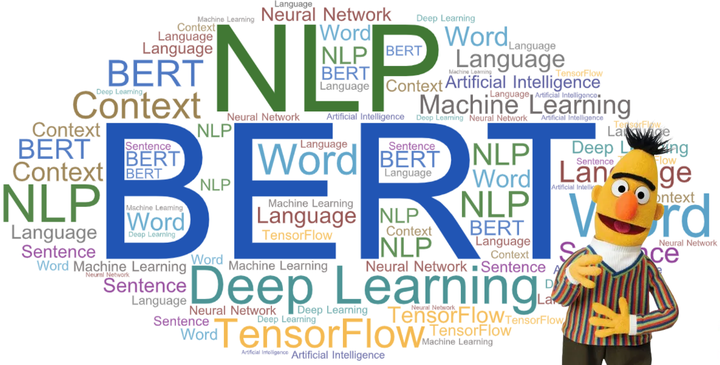

<b>INSTALACIÓN DE PAQUETES</b>

In [1]:
#!pip install -q -U tensorflow-text
#!pip install spacy
#!pip install demoji
#!pip install --upgrade confection pydantic

<b>CARGA DE LAS LIBRERÍAS NECESARIAS</b>

In [2]:
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import demoji
import nltk
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from official.nlp import optimization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout, Bidirectional,\
SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
#from keras.layers.embeddings import Embedding
from tensorflow.keras import layers, initializers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
import tensorflow_hub as hub
import tensorflow_text as text

import re
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))

import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raulartiguesfemenia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-05-24 18:12:40.590825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addo

<b>CARGA DE LOS DATOS</b>

In [3]:
df = pd.read_csv('/Users/raulartiguesfemenia/Desktop/Deep Learning/Entrega2/Text_Emotion.csv')
df.head(3)

,text,emotion
0,carefully word blog posts amount criticism hea...,☹️
1,cannot remember little mermaid feeling carefre...,🙂
2,not feeling super well turns cold knocked next...,🙂


Como se puede observar, el dataset tiene la variable <i>text</i> que será la Feature a procesar mediante <i>Bert</i> y la variable Target <i>emotion</i>, codificada en mediante Emojis. Sonrisa será equivalente a 1 y Tristeza será 0.

<b>ANÁLISIS EXPLORATORIO BÁSICO</b>

In [4]:
df.shape

(282822, 2)

In [5]:
df.info

<bound method DataFrame.info of                                                      text emotion
0       carefully word blog posts amount criticism hea...      ☹️
1       cannot remember little mermaid feeling carefre...       🙂
2       not feeling super well turns cold knocked next...       🙂
3                 feel honored part group amazing talents       🙂
4       think helping also began feel pretty lonely lo...      ☹️
...                                                   ...     ...
282817  feel honored motivated share world life changi...       🙂
282818                  feel like gloaty really delighted       🙂
282819  feel little energetic one day next several day...       🙂
282820  feel work experience fell although fantastic o...       🙂
282821  feel generous mood may give another fan fictio...       🙂

[282822 rows x 2 columns]>

<b>Distribución de la variable objetivo</b>

/Users/raulartiguesfemenia/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


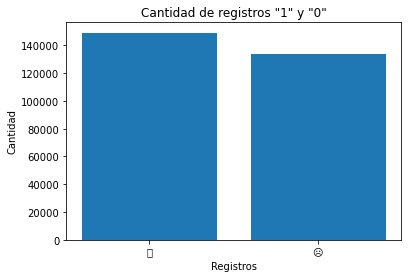

In [6]:
# Obtener la cantidad de ocurrencias de los valores en la columna "emotion"
conteo = df["emotion"].value_counts()

registros = conteo.index
cantidad = conteo.values

plt.bar(registros, cantidad)
plt.xlabel('Registros')
plt.ylabel('Cantidad')
plt.title('Cantidad de registros "1" y "0"')
plt.show()


La distribución de la variable Target es simétrica, por tanto a la hora de crear el modelo no se tendrá el problema de las frecuencia. ¡Muy buena señal!

<b>LIMPIEZA DE LOS DATOS</b>

<b>Variable Objetivo: Emotion</b>

Como se observa en las tablas anteriores, la variable objetivo está categorizada mediante emojis. Por tanto, hay que realizar una transformación. El criterio es el siguente:

* 😃 o 🙂: Clase 1
* ☹️ : Clase 0

In [7]:
def convertir_emoji_a_valor(emotion):
    demoji.download_codes()  # Descargar los códigos de emojis (solo necesario la primera vez)

    # Obtener la lista de emojis separados por comas
    lista_emojis = emotion.split(', ')
    
    # Reemplazar el emoji de sonrisa por '0' y los demás emojis por '1'
    resultado = ['1' if i == '😃' or i == '🙂' else '0' for i in lista_emojis]

    # Unir los emojis en una cadena separada por comas
    emotion = ', '.join(resultado)
    
    return emotion

# Aplicar la función a la columna 'emotion'
df['Emotion_Clean'] = df['emotion'].apply(convertir_emoji_a_valor)

# Eliminar la columna 'emotion'
df.drop('emotion', axis=1, inplace=True)

df.head(2)


/var/folders/bb/9rcbbv8x2kjb9lvr1vjr1djh0000gn/T/ipykernel_12218/3861477678.py:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()  # Descargar los códigos de emojis (solo necesario la primera vez)


,text,Emotion_Clean
0,carefully word blog posts amount criticism hea...,0
1,cannot remember little mermaid feeling carefre...,1


El tratamiento de la variable objetivo, se ha realizado de forma <b>Sastisfactoria</b>.

<b>Variable predictora: Text</b>

A continuación, se procede a realizar una limpieza de caractares especiales de la Feature: Text. En esta pueden haber símbolos extraños y esto provoca un ruido a la hora de la creación del modelo.

In [8]:
pat1 = r'http[^ ]+' # pattern to remove links
pat2 = r'www.[^ ]+' # pattern to remove links
pat3 = '[^a-zA-Z]+' # pattern to remove numbers
pat = r'|'.join((pat1, pat2, pat3))

def get_clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(pat, ' ', text) # remove pat
    text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
    text = [w for w in text if len(w)>1] # remove words with len <2
    text = (' '.join(text)).strip() # list to string
    return text

df['Text_Clean'] = [get_clean_text(t) for t in df['text']]

df.drop(columns=['text'], axis=1, inplace=True)
df.head(3)

,Emotion_Clean,Text_Clean
0,0,carefully word blog posts amount criticism hea...
1,1,cannot remember little mermaid feeling carefre...
2,1,feeling super well turns cold knocked next thr...


<b>Separación del Dataset entre Train y Test</b>

In [9]:
# Eliminar el 60% de los datos
df_sampled = df.sample(frac=0.4, random_state=42)

# Dividir el dataframe muestreado en características (X) y etiquetas (y)
X = df_sampled['Text_Clean']
y = df_sampled['Emotion_Clean']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar los tamaños de los conjuntos de datos
print("Tamaño de X_train:", len(X_train))
print("Tamaño de X_test:", len(X_test))
print("Tamaño de y_train:", len(y_train))
print("Tamaño de y_test:", len(y_test))


Tamaño de X_train: 90503
Tamaño de X_test: 22626
Tamaño de y_train: 90503
Tamaño de y_test: 22626


Se realiza la división del conjunto de datos train y test. El test estará compuesto por el 20% de las observaciones totales.

<b>ELECCIÓN DEL MODELO BERT</b>

In [11]:
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 
bert_model_name = 'bert_en_cased_L-12_H-768_A-12' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3


Este modelo de TF Hub utiliza la implementación de BERT desde el repositorio de TensorFlow Models en GitHub en tensorflow/models/official/legacy/bert. Utiliza L=12 capas ocultas (es decir, bloques de transformadores), un tamaño oculto de H=768 y A=12 cabezas de atención. Para otros tamaños de modelo, consulte la colección BERT.

Los pesos de este modelo son los publicados por los autores originales de BERT. Este modelo ha sido preentrenado para el inglés en Wikipedia y BooksCorpus. Las entradas de texto se han normalizado de forma "sin castra", lo que significa que el texto se ha reducido antes de la tokenización en piezas de palabras, y cualquier marcador de acento se ha eliminado. Para el entrenamiento, el enmascaramiento de entrada aleatorio se ha aplicado de forma independiente a las piezas de palabras (como en el documento original de BERT).

A continuación, se procede a reealizar una pequeña prueba del modelo <i>Bert</i> elegido con la primera fase del presente dataset

In [41]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

2023-05-28 08:59:00.777853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-28 08:59:00.778266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-28 08:59:00.778386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-28 08:59:00.778732: I tensorflow/core/

In [47]:
text_test = ['carefully word blog posts amount criticism hear place coming saudis non saudis goes show feeling discontent lot areas directed towards specific people never swat teams charging conversations']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :190]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :190]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :190]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  4727  1937 10679  8345  2971  5879  2100  1282  1909 21718 17294
  1116  1664 21718 17294  1116  2947  1437  2296 19959 11656  2227  1974
  1877  2002  2019  2747  1234  1309   188 20543  1929 13758 12705   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

En este caso se ha realizado un cambio en el código respeto al publico en TensorFlow, aquí se elige como ejemplo la primera fila del presente dataset y se ha cambiado el número de elementos a analiza en "Word IDs", "Inout Mask" y "Type Ids" ha 190.

<b>DEFINICIÓN DEL MODELO</b>

In [15]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

<b>Arquitecutura del modelo</b>

In [18]:
import tensorflow as tf
import tensorflow_hub as hub

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.3)(net)
  net = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

A la hora de definir el modelo, se ha cambiado el porcentaje de apagar de forma aleatoria de neuronas del 10% al 30%. Además, la última capa se ha añadidio una activación "softmax" y 2 neuronal.

<b>Funciones de pérdida y métricas</b>

In [19]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = tf.keras.metrics.CategoricalAccuracy()

Como a la hora de realizar la arquitectura de la red para la clasificación de emociones se ha creada una última capa densa con <i>2 neuronas</i> y una activación <i>softmax</i>, a la hora de definir la función de pérdida, hay que realizar un cambio, está pasa de <i>BinaryCrossentropy</i> a <i>CategoricalCrossentropy</i>. Ocurre exactamente lo mismo, en las métricas.

<b>Optimizador</b>

In [20]:
import tensorflow as tf

# Convertir X_train a un objeto tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train)

# Calcular la cardinalidad
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()

# Resto del código
epochs = 5
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-6
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

En esta sección, se utiliza un <i>learning rate</i> de 3e-6. Eso si el optimizador se queda igual que el que estaba por defecto (<i>Adam</i>).

<b>Cargar el modelo Bert y Entrenamiento</b>

In [21]:
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

2023-05-24 18:18:04.332331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-24 18:18:04.332775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-24 18:18:04.332892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-24 18:18:04.333222: I tensorflow/core/

2023-05-24 18:18:05.706460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-05-24 18:18:05.733971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]
2023-05-24 18:18:14.930309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-05-24 1

In [22]:
from keras.utils import to_categorical

# Modificar y_train
y_train_modified = to_categorical(y_train, num_classes=2)

# Modificar y_test
y_test_modified = to_categorical(y_test, num_classes=2)

Como se quiero realizar una última capa, que indique la probabilidad de que el texto anaizado sea negativo o contento, hay que asignar a la variable objetivo dos clases para que en la red neuronal se detecte de la forma adecuada.

In [23]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=X_train,
                               y=y_train_modified,
                               validation_data=(X_test, y_test_modified),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Epoch 1/5


2023-05-24 18:18:40.398593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-05-24 18:18:40.398756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_2' with dtype int32 and shape [?,128]
	 [[{{node inputs_2}}]]
2023-05-24 18:18:45.404140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/bert_encoder/StatefulPartitionedCall_grad/bert_encoder/StatefulPart

2023-05-24 18:18:46.029625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-05-24 18:18:46.029731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-05-24 18:18:46.029779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) 

2023-05-24 18:18:46.692907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_3}}]]
2023-05-24 18:18:46.693017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4' with dtype float and shape [?,?,768]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_4}}]]
2023-05-24 18:18:46.693066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) 

2829/2829 [==============================] - 36480s 13s/step - loss: 0.4247 - categorical_accuracy: 0.7846 - val_loss: 0.1132 - val_categorical_accuracy: 0.9565
Epoch 2/5
2829/2829 [==============================] - 35947s 13s/step - loss: 0.0990 - categorical_accuracy: 0.9615 - val_loss: 0.0715 - val_categorical_accuracy: 0.9720
Epoch 3/5
2829/2829 [==============================] - 36483s 13s/step - loss: 0.0686 - categorical_accuracy: 0.9739 - val_loss: 0.0627 - val_categorical_accuracy: 0.9751
Epoch 4/5
2829/2829 [==============================] - 34605s 12s/step - loss: 0.0547 - categorical_accuracy: 0.9803 - val_loss: 0.0839 - val_categorical_accuracy: 0.9757
Epoch 5/5
2829/2829 [==============================] - 36161s 13s/step - loss: 0.0450 - categorical_accuracy: 0.9852 - val_loss: 0.0770 - val_categorical_accuracy: 0.9754


Se entrena el modelo, obteniendo buenos resultados a primera vista, eso si, asumiendo un coste computacional elevada ya que para entrenar la red neuronal ha llevada aproximadamente 3 días.

<b>EVALUCIÓN DEL MODELO</b>

In [25]:
loss, accuracy = classifier_model.evaluate(X_test, y_test_modified)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

708/708 [==============================] - 2657s 4s/step - loss: 0.0770 - categorical_accuracy: 0.9754
Loss: 0.0769728273153305
Accuracy: 0.9754264950752258


Los resultados son espectaculares, se obtienedo que el 97.54% de las veces la red neuronal acierta la categoria del texto, con un error de 0.07.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


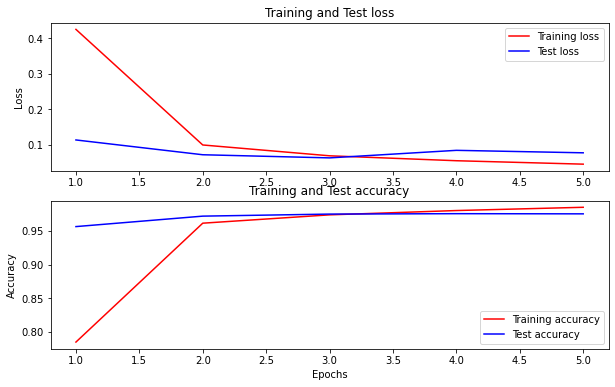

In [26]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Observando los dos gráficos anteriores, se observa que la red neuronal aprende de la forma adecuada. Eso si, en el acutal modelo habría un sobreajuste de los datos a partir de aproximadamente la época 3.

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = classifier_model.predict(X_test)

708/708 [==============================] - 2681s 4s/step


In [33]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred_labels = tf.argmax(y_pred, axis=1)

# Convertir las etiquetas reales a valores numéricos
y_test_numeric = y_test.astype(int)

# Crear la matriz de confusión
cm = confusion_matrix(y_test_numeric, y_pred_labels)

# Calcular las métricas
accuracy = round(accuracy_score(y_test_numeric, y_pred_labels)*100,2)
precision = round(precision_score(y_test_numeric, y_pred_labels, average='macro')*100,2)
recall = round(recall_score(y_test_numeric, y_pred_labels, average='macro')*100,2)
f1 = round(f1_score(y_test_numeric, y_pred_labels, average='macro')*100,2)

# Imprimir las métricas
print("Matriz de confusión:")
print(cm)
print("")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Matriz de confusión:
[[10385   212]
 [  344 11685]]

Accuracy: 97.54
Precision: 97.51
Recall: 97.57
F1-score: 97.53


Como se ha comentado anteriormente, los resultados obtenidos con la red neuronal entrenada, no podrían ser mejores. Las métricas de <i>Precisión y Recall</i> indican que el modelo acierta de la misma forma si el texto es positivo o negativo, es decir, no hay ningún problema de asimetria y las scores son muy buenas.

<b>Guardamos el modelo</b>

In [27]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2023-05-26 21:38:07.470027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-05-26 21:38:07.504986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'text' with dtype string and shape [?]
	 [[{{node text}}]]
2023-05-26 21:38:07.655506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype int32 and shape [?,128]
	 [[{{node inputs}}]]
2023-05-26 21:38:07.655617

2023-05-26 21:38:09.894957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-05-26 21:38:10.103988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'text' with dtype string and shape [?]
	 [[{{node text}}]]
2023-05-26 21:38:10.250739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string and shape [?]
	 [[{{node inputs}}]]
2023-05-26 21:38:10.362770: I

INFO:tensorflow:Assets written to: ./imdb_bert/assets


INFO:tensorflow:Assets written to: ./imdb_bert/assets


<b>EXPORTAR PARA INFERENCIA</b>

In [34]:
reloaded_model = tf.saved_model.load(saved_model_path)

2023-05-27 08:53:15.650914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-27 08:53:15.651454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-27 08:53:15.651556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-05-27 08:53:15.651936: I tensorflow/core/

<b>Test con una frase nunca vista antes</b>

In [38]:
def print_my_examples(inputs, results):
  result_for_printing = [
    f'input: {inputs[i]:<180} : score for class 0: {results[i][0]:.6f}, score for class 1: {results[i][1]:.6f}'
    for i in range(len(inputs))
  ]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'said expect say feel dumb stupid ever say guess hates kind thing'
]

reloaded_results = tf.nn.softmax(reloaded_model(tf.constant(examples)))
original_results = tf.nn.softmax(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)


Results from the saved model:
input: said expect say feel dumb stupid ever say guess hates kind thing                                                                                                                     : score for class 0: 0.730990, score for class 1: 0.269010

Results from the model in memory:
input: said expect say feel dumb stupid ever say guess hates kind thing                                                                                                                     : score for class 0: 0.730990, score for class 1: 0.269010



Para coraborar por última vez la eficacia del modelo creada, se añade una nueva frase, la cual es negativa, para ver como la clasifica el modelo. Este indica que la probabilidad de que el nueva input sea negativo es del 0.7. <b>Éxito</b>.

Este código proviene de la página web de TensorFow, pero se han realizado cambios. El primer cambio ha sido en la longitud máximo de los inputs, antes estaba a <i>30 y ahora a 180</i>, ya que el data set usado en el presente proyecto tiene frases mucho más largas. Además, el otro cambio ha sido a la hora de realizar la predicción, en la página web utilizaban la función <i>sigmoid</i> y se ha cambiado a <i>softmax</i>.

<b>CONCLUSIÓN FINAL</b>

En el presente proyecto, se ha decidido tomar una dirección un poco diferente planteado desde la asignatura. Se ha realizado una investigación de bases de datos adecuadas para realizar un <b>análisis sentimental mediante Texto con Bert</b> en Kaggle. La base de datos contiene frases y hay que clasificarlas en <i>positivas 1</i> o en <i>negativas 0.</i>. Se ha realizado una limpieza de datos que nunca antes se habia hecho para tratar con los emojis. 

Por otra parte, se ha utilizado el modelo <i>bert_en_cased_L-12_H-768_A-12 de BERT</i>. Posteriormente, se ha entrenado una red neuronal básica que se ofrece en la página web de Tenserflow. Cambiando el número de épocas y las características de la útlima capa: Activación <i>softmax,neuronas 2 y loss categoricalcrossentropy</i>.

Con los respectivos cambios en el procesamiento de datos y arquitectura de la red neuronal, se ha obtenido una resultados sorprendentes, que se pueden observar en la tabla siguiente:

<table>
    <tr>
        <th>TP</th>
        <th>FP</th>
        <th>FN</th>
        <th>TN</th>
        <th>Accuracy</th>
        <th>Loss</th>
        <th>Recall</th>
        <th>F1-Score</th>
    </tr>
    <tr>
        <td>10385</td>
        <td>212</td>
        <td>344</td>
        <td>11685</td>
        <td>97.54%</td>
        <td>0.077</td>
        <td>97.57%</td>
        <td>97.53%</td>
    </tr>
</table>
